# Latent Dirichlet Allocation

In this phase, we implement a topic modelling technique called Latent Dirichlet Allocation (LDA) to our BG_lemma data set. LDA is an unsupervised machine learning technique where we attempt to discover inherent topics within our data set.

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
from gensim import corpora
from gensim.models import TfidfModel, LdaMulticore, LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib import transforms
from wordcloud import WordCloud
import random
import numpy as np

%matplotlib inline

In [2]:
%run preprocessing.ipynb # import preprocessing.ipynb to use the data sets and functions

There are 2 data frames to be used for classification:
BG_stem
BG_lemma

There are 4 feature extraction methods:
unigram_features:                   all words
bigram_features:                    all words and most significant bigrams
informative_word_features:          most significant words only
informative_word_bigram_features:   most significant words and bigrams


We shall make use of our lemmatised and cleaned up BG_lemma data frame to implement the LDA model. LDA is a Bag-of-Words model, therefore we first need to create our corpus of words or/and bigrams. We create bigrams or collocations of words using the Phrases function from gensim. 

First, we create a dictionary containing the number of times a word or a bigram appears in our data set. We then convert the documents to a Bag-of-Words model using gensim's doc2bow. Our corpus will be the entirety of our BOW reviews.

We attempt to see which of the combination of parameters would yield the best result, i.e. the best topic coherence, calculated by the metric c_v.

The parameters are either filtering frequent or infrequent words, the number of topics and applying a term frequency–inverse document frequency (TF-IDF) mask to our corpus. 

For the first parameter, we use gensim's filter_extremes method to remove words that appear in less than a given number of reviews and above a proportion of the total review. For example, we remove words that appear in less than 10 documents (too infrequent) and words that appear in more than 10% of the whole corpus (too much). We focus more on the upper limit since the frequent word carry more weight than the rare ones.

In [3]:
# function to create gensim corpus and dictionary
def corpus(tokens, filter_extremes=True, below=10, above=0.1, tfidf=False):
    # create bigrams and dictionary
    dictionary = corpora.Dictionary(tokens)

    # Filter the dictionary below and above certain threshold
    if filter_extremes:
        print('\nFilter tokens that appears in more than {}% of corpus.'.format(above*100))
        print('Size of dictionary before filter: {}'.format(len(dictionary)))
        dictionary.filter_extremes(no_below=below, no_above=above)
        print('Size of dictionary after filter: {}'.format(len(dictionary)))

    # Convert the documents into Bag-of-Words or TF-IDF
    if tfidf:
        corpus_tfidf = [dictionary.doc2bow(t) for t in tokens]
        tfidf = TfidfModel(corpus_tfidf)
        corpus = tfidf[corpus_tfidf]
    else:
        corpus = [dictionary.doc2bow(t) for t in tokens]

    return corpus, dictionary

In [4]:
# function to find optimal number of k topics based on c_v coherence metric
def coherence(corpus, dictionary, texts, max_topics, min_topics=2, steps=1):
    topic_coherence = []
    lda_model = []
    print('Processing...')
    for ktopics in range(min_topics, max_topics, steps):
        model = LdaModel(corpus=corpus, alpha='auto', id2word=dictionary, num_topics=ktopics)
        lda_model.append(model)
        
        coh_model = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, texts=texts, coherence='c_v')
        topic_coherence.append(coh_model.get_coherence())
    print('Fitting completed.')
    return lda_model, topic_coherence

In [5]:
# create bigrams
token = BG_lemma['tokens'].copy()
phrases = Phrases(token)
bigrams = Phraser(phrases)
token = [bigrams[t] for t in token]

# create different corpus
corpus_all, dict_all = corpus(token, filter_extremes=False)
corpus_tfidf, dict_tfidf = corpus(token, filter_extremes=False, tfidf=True)
corpus_10, dict_10 = corpus(token, filter_extremes=True, below=10, above=0.1)
corpus_50, dict_50 = corpus(token, filter_extremes=True, below=10, above=0.5)


Filter tokens that appears in more than 10.0% of corpus.
Size of dictionary before filter: 12460
Size of dictionary after filter: 1869

Filter tokens that appears in more than 50.0% of corpus.
Size of dictionary before filter: 12460
Size of dictionary after filter: 1914


We then try to fit several lda models with different number of k ranging from 2 to 10. We do not want too much topics as that will similar keywords will appear within different topics and it would decrease understandability. Hence, we use a max of k=10. We intend to see which would yield the best result in terms of topic coherence. The metric used is c_v.

In [6]:
# topic coherence for the corpuses created above. 
# k from 2 to 10. 
# This means that each model takes 9 iterations to complete.
np.random.seed(6)
model_all, coherence_all = coherence(corpus=corpus_all, dictionary=dict_all, texts=token, max_topics=11, steps=1)
model_tfidf, coherence_tfidf = coherence(corpus=corpus_tfidf, dictionary=dict_tfidf, texts=token, max_topics=11, steps=1)
model_10, coherence_10 = coherence(corpus=corpus_10, dictionary=dict_10, texts=token, max_topics=11, steps=1)
model_50, coherence_50 = coherence(corpus=corpus_50, dictionary=dict_50, texts=token, max_topics=11, steps=1)

Processing...
Fitting completed.
Processing...
Fitting completed.
Processing...
Fitting completed.
Processing...
Fitting completed.


We then plot the topic coherence for each different parameters against the number of topics to find the optimal model.

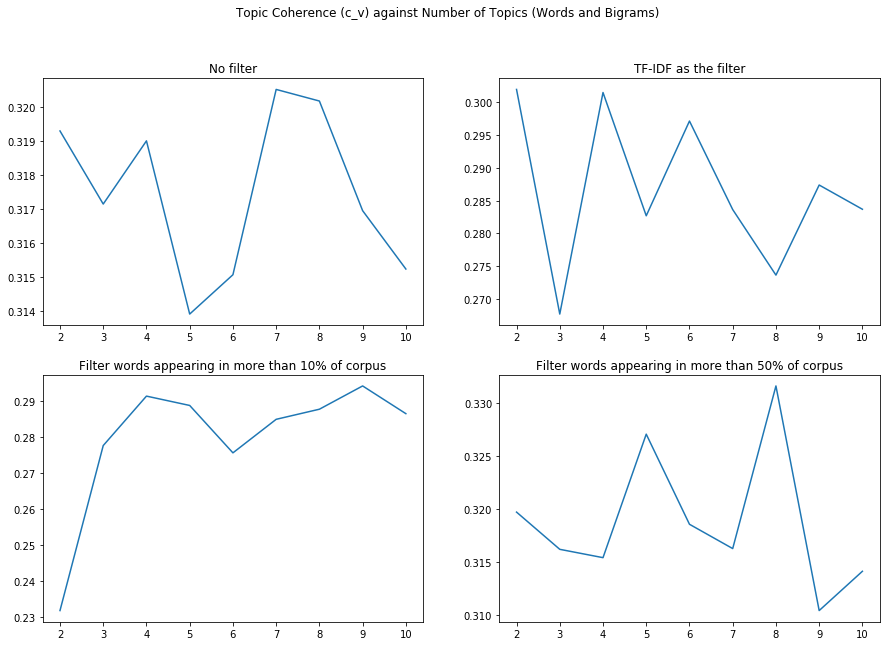

In [7]:
# plot topic coherence against number of topics (words and bigrams)
k = range(2, 11, 1)
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Topic Coherence (c_v) against Number of Topics (Words and Bigrams)')

ax1 = fig.add_subplot(221)
ax1.plot(k, coherence_all)
ax1.set_title('No filter')

ax2 = fig.add_subplot(222)
ax2.plot(k, coherence_tfidf)
ax2.set_title('TF-IDF as the filter')

ax3 = fig.add_subplot(223)
ax3.plot(k, coherence_10)
ax3.set_title('Filter words appearing in more than 10% of corpus')

ax4 = fig.add_subplot(224)
ax4.plot(k, coherence_50)
ax4.set_title('Filter words appearing in more than 50% of corpus')

plt.show()

The highest coherence score seems to be with 50% filter and k=8. Let's look at the model to see if the topics are interpretable to us.

In [8]:
# actual coherence score for model_50[6]
print(coherence_50[6])

0.3316578580775209


We visualise the lda model with k=8 and 50% filter by using pyLDAvis. 

In [9]:
opt_model = model_50[6]
model_display = pyLDAvis.gensim.prepare(opt_model, corpus_50, dict_50, sort_topics=False) # sort_topics=False to ensure topics are the same as gensim
pyLDAvis.display(model_display)

At first, when the relevance metric, lambda is set to 1, we do not see any distinguishing pattern within the topics. The reason for this is because pyLDAvis is showing the terms based on the frequency rank. 

We can see that a lower relevance term is much more suitable here as the data set is about British Gas and certain common words such as engineer would come out in every topic as they are really frequent within the whole corpus. Hence, if we lower the lambda value or even setting it to 0, we can get terms that are more relevant to a particular topic instead of terms that are more frequent within the whole corpus. 

From the intertopic distance map, we can deduce that topics 7 and 3 are probably more dominant with negative sentiments while topics 1 and 5 are more dominant with positive sentiments since they are the farthest between each another. The rest of the topics are probably in between the two extremes.

Let's try to name these topics and visualise the terms based on relevance metric.

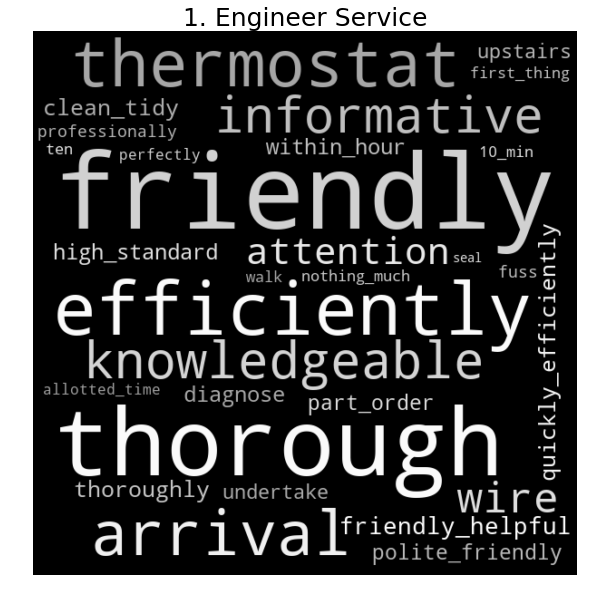

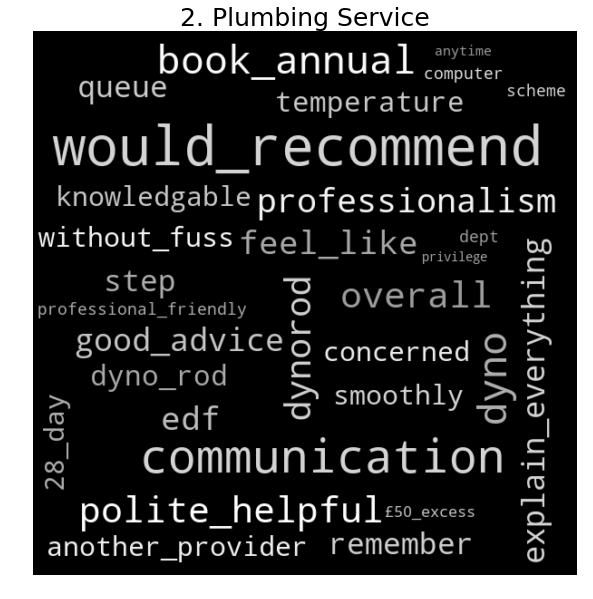

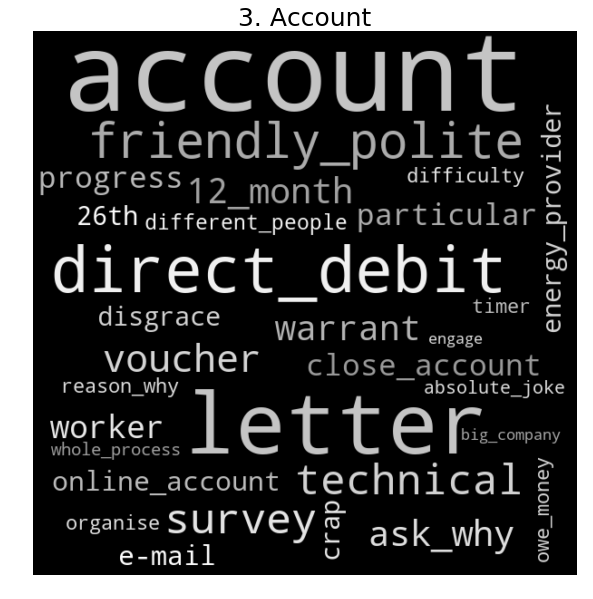

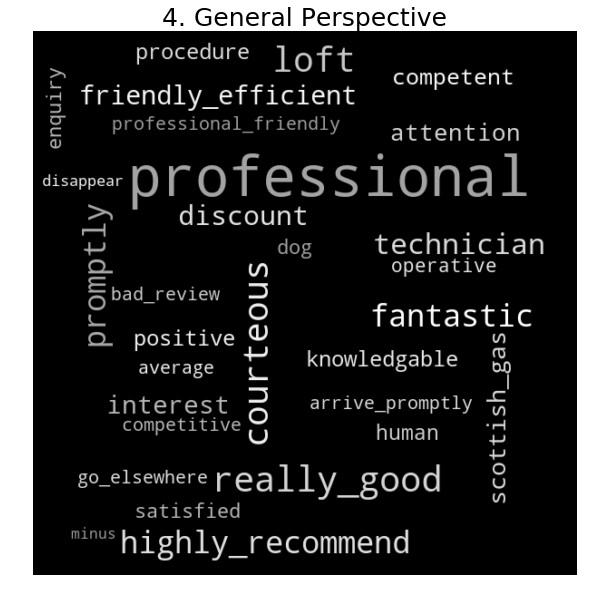

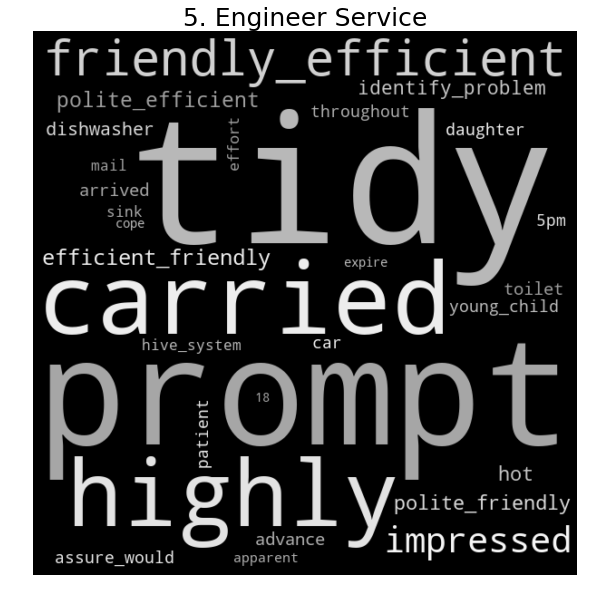

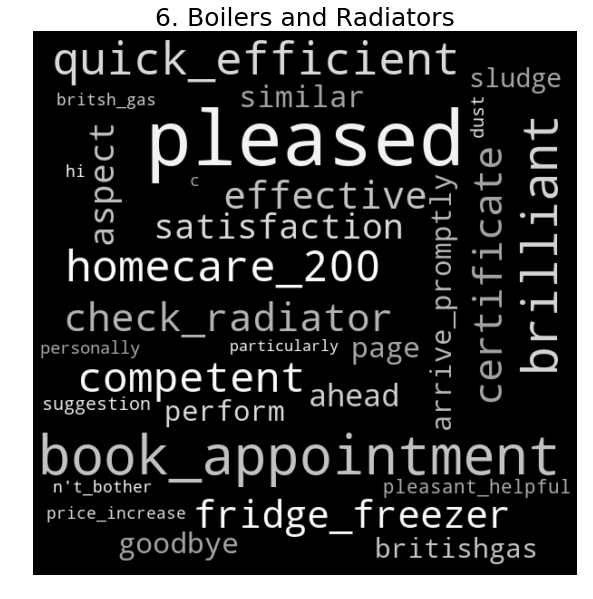

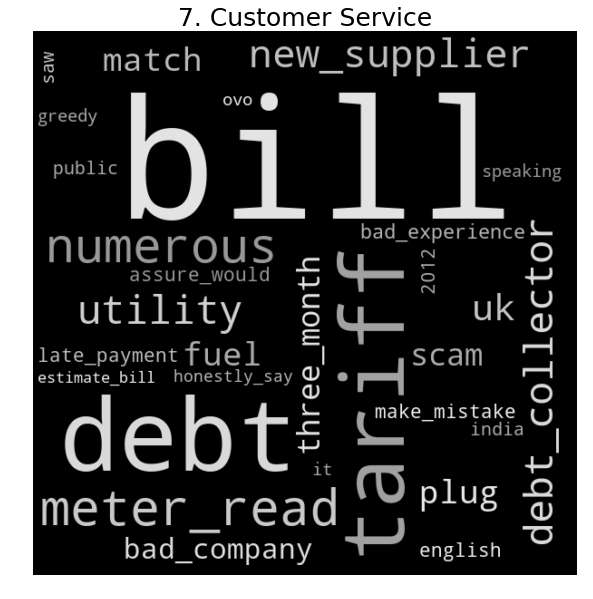

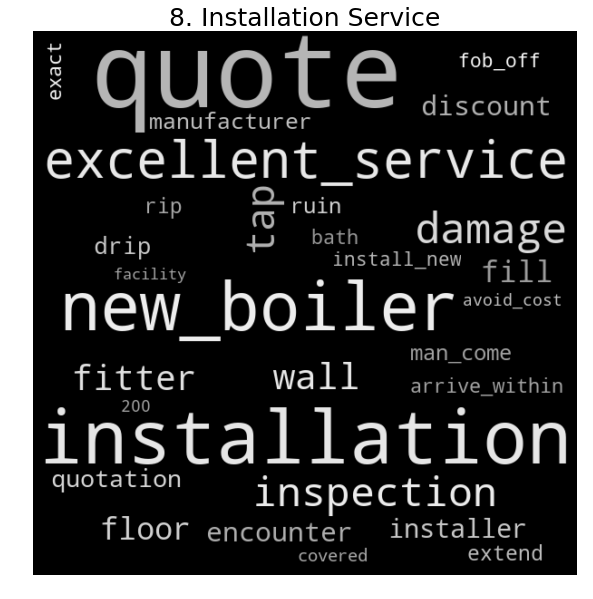

In [10]:
# try to name the topics
topics_name = { 0: "1. Engineer Service", # topic 1
                1: "2. Plumbing Service", # topic 2
                2: "3. Account", # topic 3
                3: "4. General Perspective", # topic 4
                4: "5. Engineer Service", # topic 5
                5: "6. Boilers and Radiators", # topic 6
                6: "7. Customer Service", # topic 7
                7: "8. Installation Service", # topic 8
              }

# specify relevance metric
lambda_ = 0

model_vis = model_display.topic_info
model_vis['relevance'] = lambda_ * model_vis['logprob'] + (1 - lambda_) * model_vis['loglift']

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

for key, value in topics_name.items():
    df = model_vis[model_vis.Category=='Topic'+str(key+1)].sort_values(by='relevance', ascending=False).head(30)
    df.set_index(df['Term'], inplace=True)
    d = df.set_index('Term').to_dict()['Freq']

    wordcloud = WordCloud(width=600, height=600, color_func=grey_color_func, margin=10, random_state=6)
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15, 10))
    plt.title(value, fontsize=25)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Comparing topic 7, which is furthest to the left side of the intertopic distance, with topic 1, which is furthest to the right side of the intertopic distance, there are certain insights that we can take. It seems that British Gas's engineer service has a positive sentiment while its customer service does not. We shall further analyse these relationships in analysis. ipynb. 

Next, we apply our LDA model to our tokens to find each review's topic based on the highest probability.

In [11]:
# apply LDA model to token (gensim's topic start with 0)
np.random.seed(6)
score = opt_model[corpus_50]
topic_prob = map(lambda x: max(x, key=lambda item: item[1]), score)
topic_scores = pd.DataFrame(list(zip(token, topic_prob)), columns=['tokens', 'score'])
topic_scores[['topic #', 'prob']] = topic_scores['score'].apply(pd.Series)
topic_scores['topic name'] = topic_scores['topic #'].map(topics_name)

topic_scores.head()

,tokens,score,topic #,prob,topic name
0,"[hive, engineer, fail, show, twice, take, two,...","(5, 0.98281604)",5.0,0.982816,6. Boilers and Radiators
1,"[move, sse, british_gas, sse, useless, get, sm...","(4, 0.76961285)",4.0,0.769613,5. Engineer Service
2,"[engineer, rude, surely.3, time, get, back, jo...","(0, 0.96946865)",0.0,0.969469,1. Engineer Service
3,"[firstly, app, never, work, people, ring, help...","(1, 0.65276945)",1.0,0.652769,2. Plumbing Service
4,"[con, leave, right, centre, 14, year, soon, te...","(2, 0.6077942)",2.0,0.607794,3. Account


In [12]:
# join prob and topic name to original data frame so we can analyse it further
BG_lemma = BG_lemma.reset_index(drop=True) # reset index so that it matches topic_scores
BG_lemma['prob of topic #'] = topic_scores['prob']
BG_lemma['topic'] = topic_scores['topic name']
BG_lemma['tokens'] = topic_scores['tokens'] # replace original data set tokens by LDA model tokens 

BG_lemma.head()

,rating,reviews,date,sentiment,tokens,prob of topic #,topic
0,1,Hive engineer failed to show twice...,09/07/2018,Negative,"[hive, engineer, fail, show, twice, take, two,...",0.982816,6. Boilers and Radiators
1,1,I moved from SSE to British Gas be...,09/07/2018,Negative,"[move, sse, british_gas, sse, useless, get, sm...",0.769613,5. Engineer Service
2,1,There engineers were rude and sur...,09/07/2018,Negative,"[engineer, rude, surely.3, time, get, back, jo...",0.969469,1. Engineer Service
3,1,Firstly the App never works and th...,06/07/2018,Negative,"[firstly, app, never, work, people, ring, help...",0.652769,2. Plumbing Service
4,1,Conned me left right and centre. B...,05/07/2018,Negative,"[con, leave, right, centre, 14, year, soon, te...",0.607794,3. Account


Lastly, we save our model and this data frame into a pickle file for future analysis in analysis.ipynb.

In [13]:
opt_model.save('BG_lda.model')
BG_lemma.to_pickle('BG_lda_pickle')